In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

FLX_TRAIN_FILE = ".\\FLX_model\\FLX_train_dict_old_features.pkl"
FLX_VAL_FILE = ".\\FLX_model\\FLX_validation_dict_old_features.pkl"

EPM_TRAIN_FILE = ".\\EPM_model\\EPM_train_dict_old_features.pkl"
EPM_VAL_FILE = ".\\EPM_model\\EPM_validation_dict_old_features.pkl"

OFT_TRAIN_FILE = ".\\OFT_model\\OFT_train_dict_old_features_hand_picked.pkl"
OFT_VAL_FILE = ".\\OFT_model\\OFT_validation_dict_old_features_hand_picked.pkl"

FEATURE_LIST = ['X_power_1_2','X_coh_1_2','X_gc_1_2']
FEATURE_VECTOR = FEATURE_LIST

UMC_PATH = ".\\Universal-Mouse-Code\\"

sys.path.append(UMC_PATH)
#from dCSFA_model import dCSFA_model
import umc_data_tools as umc_dt
from dCSFA_NMF import dCSFA_NMF

if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"


print("Using device: %s"%(device))

#For Consistency
RANDOM_STATE=42

import pandas as pd
def make_projection_csv(pickle_file,model,X_feature_list,other_features,save_file):

    with open(pickle_file,'rb') as f:
        project_dict = pickle.load(f)
    
    X_project = np.hstack([project_dict[feature] for feature in X_feature_list])
    s = model.transform(X_project)[3]
    s = s[:,0]
    save_dict = {}
    save_dict['scores'] = s
    for feature in other_features:
        save_dict[feature] = project_dict[feature]

    df = pd.DataFrame.from_dict(save_dict)
    df.to_csv(save_file,index=False,header=True)

    return df

Using device: cuda:0


In [2]:
with open(OFT_TRAIN_FILE,'rb') as f:
    train_dict = pickle.load(f)

with open(OFT_VAL_FILE,'rb') as f:
    val_dict = pickle.load(f)

running_idx = 0
feature_groups = []
for idx,feature in enumerate(FEATURE_LIST):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in FEATURE_LIST]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature] for feature in FEATURE_LIST])#*scale_vector
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature] for feature in FEATURE_LIST])#*scale_vector
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

In [3]:
with open(FLX_TRAIN_FILE,"rb") as f:
    flx_train_dict = pickle.load(f)

with open(FLX_VAL_FILE,"rb") as f:
    flx_validation_dict = pickle.load(f)

flx_X_train = np.hstack([flx_train_dict[feature] for feature in FEATURE_LIST])
flx_y_train = flx_train_dict['y_flx']
flx_y_mouse_train = flx_train_dict['y_mouse']
flx_y_expDate_train = flx_train_dict['y_expDate']
flx_y_time_train = flx_train_dict['y_time']

flx_X_validation = np.hstack([flx_validation_dict[feature] for feature in FEATURE_LIST])
flx_y_validation = flx_validation_dict['y_flx']
flx_y_mouse_validation = flx_validation_dict['y_mouse']
flx_y_expDate_validation = flx_validation_dict['y_expDate']
flx_y_time_validation = flx_validation_dict['y_time']

flx_X = np.vstack([flx_X_train,flx_X_validation])
flx_y_task = np.hstack([flx_y_train,flx_y_validation])
flx_y_mouse = np.hstack([flx_y_mouse_train,flx_y_mouse_validation])
flx_y_expDate = np.hstack([flx_y_expDate_train,flx_y_expDate_validation])
flx_y_time = np.hstack([flx_y_time_train,flx_y_time_validation])

In [4]:
with open(EPM_TRAIN_FILE,"rb") as f:
    epm_train_dict = pickle.load(f)

with open(EPM_VAL_FILE,"rb") as f:
    epm_validation_dict = pickle.load(f)
#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature] for feature in FEATURE_LIST])
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature] for feature in FEATURE_LIST])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

epm_X = np.vstack([X_train_task,X_val_task])
epm_y_task = np.hstack([y_train_task,y_val_task])
epm_y_mouse = np.hstack([y_mouse_train_task,y_mouse_val_task])
epm_y_time = np.hstack([y_time_train_task,y_time_val_task])


In [8]:
mt_X_train = np.vstack([flx_X_train,oft_X_train,X_train])
mt_y_train = np.hstack([flx_y_train,oft_y_task_train,y_in_task_mask_train])
mt_y_mouse_train = np.hstack([flx_y_mouse_train,oft_y_mouse_train,y_mouse_train])

mt_X_val = np.vstack([flx_X_validation,oft_X_val,X_val])
mt_y_val = np.hstack([flx_y_validation,oft_y_task_val,y_in_task_mask_val])
mt_y_mouse_val = np.hstack([flx_y_mouse_validation,oft_y_mouse_val,y_mouse_val])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()

In [6]:
N_COMPONENTS=20
DIM_IN = flx_X_train.shape[1]
'''model = dCSFA_NMF(n_components=N_COMPONENTS,dim_in=DIM_IN,device='auto',n_intercepts=intercept_mask.shape[1],
                n_sup_networks=1,optim_name='Adam',recon_loss='IS',sup_recon_weight=1,sup_weight=1,
                useDeepEnc=True,h=256,sup_recon_type="Residual",feature_groups=feature_groups)
model.fit(mt_X_train,mt_y_train,intercept_mask=intercept_mask,batch_size=128,lr=1e-3,
        n_pre_epochs=100,n_epochs=1500,verbose=True,pretrain=True,best_model_name="flippedMT_Network_March_25_state_dict.pt")
torch.save(model,"flipped_MT_Network_March_25.pt")'''
model = torch.load("MT_Network_March_25.pt",map_location='cpu')
model.device='cpu'

In [12]:
y_pred, s = model.predict(mt_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_train,mt_y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_train,mt_y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

y_pred, s = model.predict(mt_X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_val,mt_y_mouse_val)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_val,mt_y_mouse_val,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04191': 1.0, 'Mouse04201': 1.0, 'Mouse04202': 1.0, 'Mouse04205': 0.998442367601246, 'Mouse04215': nan, 'Mouse0630': 1.0, 'Mouse0633': 1.0, 'Mouse0634': 1.0, 'Mouse0641': 1.0, 'Mouse0642': 1.0, 'Mouse0643': 1.0, 'Mouse1551': 1.0, 'Mouse3191': 1.0, 'Mouse3192': nan, 'Mouse3193': 0.999515503875969, 'Mouse3194': 1.0, 'Mouse3202': nan, 'Mouse3203': 1.0, 'Mouse39114': 0.9645833333333333, 'Mouse39115': 1.0, 'Mouse39121': 1.0, 'Mouse39124': 1.0, 'Mouse39125': 1.0, 'Mouse39133': 1.0, 'Mouse6291': 1.0, 'Mouse6292': 1.0, 'Mouse6293': 1.0, 'Mouse6662': 1.0, 'Mouse6664': 1.0, 'Mouse6674': 1.0, 'Mouse69064': 1.0, 'Mouse69072': 1.0, 'Mouse69074': 0.9984848484848484, 'Mouse8580': 1.0, 'Mouse8581': 1.0, 'Mouse8582': 1.0, 'Mouse8881': 1.0, 'Mouse8891': 1.0, 'Mouse8893': 1.0, 'Mouse8894': 1.0, 'Mouse99003': nan}
Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has on

In [9]:
y_pred, s = model.predict(mt_X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_train,mt_y_mouse_train)
print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_train,mt_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(mt_X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_val,mt_y_mouse_val)
print("val roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_val,mt_y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


train roc auc mean: 1.00 +/- 0.00
Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
train mw auc mean: 0.00 +/- 0.00
val roc auc mean: 0.64 +/- 0.03
val mw auc mean: 0.24 +/- 0.03


## EPM Performance

In [14]:
y_pred, s = model.predict(X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_train,y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_train,y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

y_pred, s = model.predict(X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_val,y_mouse_val)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_val,y_mouse_val,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04201': 1.0, 'Mouse0630': 1.0, 'Mouse0633': 0.9991816693944353, 'Mouse0634': 0.9959349593495934, 'Mouse0641': 0.9981060606060606, 'Mouse0642': 1.0, 'Mouse0643': 1.0, 'Mouse1551': 1.0, 'Mouse39115': 1.0, 'Mouse39121': 0.9983498349834983, 'Mouse39125': 1.0, 'Mouse6291': 1.0, 'Mouse6292': 0.9973404255319148, 'Mouse6293': 0.9974747474747474, 'Mouse6662': 1.0, 'Mouse6664': 0.9958333333333333, 'Mouse6674': 1.0, 'Mouse69074': 0.9615384615384616, 'Mouse8580': 1.0, 'Mouse8581': 1.0, 'Mouse8582': 1.0, 'Mouse8881': 0.9957983193277311, 'Mouse8891': 0.9960629921259843, 'Mouse8893': 0.9974402730375427, 'Mouse8894': 0.9973118279569892}
Training Mann Whitney AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse04201': (0.0, 1.948546217773956e-107), 'Mouse0630': (0.0, 5.695529992412083e-84), 'Mouse0633': (0.0, 2.2780270550768948e-71), 'Mouse0634': (0.0, 7.095752964106866e-68), 'Mouse0641': (0.0, 1.8964750717736742e-41), 'Mouse0642': (0.0, 4.76252411748

In [11]:
y_pred, s = model.predict(X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,~y_in_task_mask_train,y_mouse_train)
print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~y_in_task_mask_train,y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,~y_in_task_mask_val,y_mouse_val)
print("val roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~y_in_task_mask_val,y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

train roc auc mean: 1.00 +/- 0.00
train mw auc mean: 1.00 +/- 0.00
val roc auc mean: 0.62 +/- 0.03
val mw auc mean: 0.72 +/- 0.02


In [12]:
umc_dt.make_recon_plots(model,X_train,0,task="MT onto EPM (HC vs Task) Train",saveFile="flipped_mt_onto_epm_train_recon.png")
umc_dt.make_recon_plots(model,X_val,0,task="MT onto EPM (HC vs Task) val",saveFile="flipped_mt_onto_epm_val_recon.png")
df = make_projection_csv(EPM_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = r".\\flipped_MT_onto_EPM_HC_vs_Task_Train_Projection_2022_March_25.csv")

df = make_projection_csv(EPM_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = r".\\flipped_MT_onto_EPM_HC_vs_Task_Val_Projection_2022_March_25.csv")

KeyboardInterrupt: 

### FLX Performance

In [17]:
y_pred, s = model.predict(flx_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_train,flx_y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_train,flx_y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

y_pred, s = model.predict(flx_X_validation,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_validation,flx_y_mouse_validation)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_validation,flx_y_mouse_validation,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse3191': 0.9822732012513035, 'Mouse3193': 0.9699833240689272, 'Mouse3194': 0.9609503003823048, 'Mouse3202': nan, 'Mouse3203': 0.999418942475305, 'Mouse99003': nan}
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
Training Mann Whitney AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse3191': (2.943966311604703e-07, 0.0), 'Mouse3193': (0.0, 0.0), 'Mouse3194': (1.4938447620424801e-06, 0.0), 'Mouse3203': (0.0, 0.0)}
Validation ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse3192': 0.6839444199274296}
Validation MW AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse3192': (0.184976279788173, 7.762922412346218e-234)}


C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [17]:
~flx_y_validation

array([-2, -2, -2, ..., -1, -1, -1], dtype=int32)

In [18]:
umc_dt.lpne_auc(y_pred,~flx_y_validation.astype(bool),flx_y_mouse_validation,s,True)

{'auc_method': 'mannWhitneyU',
 'Mouse3192': (0.819059680543297, 8.218511973425894e-240)}

In [16]:
y_pred, s = model.predict(flx_X_train,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~flx_y_train,flx_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(flx_X_validation,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~flx_y_validation,flx_y_mouse_validation,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

Mouse  Mouse3191  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3193  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
train mw auc mean: nan +/- nan
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
val mw auc mean: nan +/- nan


C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
e:\Anx-Analyses-March-7\Final_Analyses\.\Universal-Mouse-Code\umc_data

In [ ]:
umc_dt.make_recon_plots(model,flx_X_train,0,task="MT onto FLX Train",saveFile="ds_mt_onto_flx_train_recon.png")
umc_dt.make_recon_plots(model,flx_X_validation,0,task="MT onto FLX val",saveFile="ds_mt_onto_flx_val_recon.png")
df = make_projection_csv(FLX_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_flx'],
                    save_file = r".\\DS_MT_onto_FLX_flx_vs_saline_Train_Projection_2022_March_25.csv")

df = make_projection_csv(FLX_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_flx'],
                    save_file = r".\\DS_MT_onto_FLX_flx_vs_saline_Val_Projection_2022_March_25.csv")

## OFT Performance

In [18]:
y_pred, s = model.predict(oft_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_train,oft_y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_train,oft_y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

y_pred, s = model.predict(oft_X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_val,oft_y_mouse_val)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_val,oft_y_mouse_val,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04191': 0.995049504950495, 'Mouse04201': 1.0, 'Mouse04202': 0.9982014388489209, 'Mouse04205': 0.9922118380062305, 'Mouse04215': nan, 'Mouse3191': 0.9653465346534653, 'Mouse3192': nan, 'Mouse3193': 0.9867924528301887, 'Mouse3194': nan, 'Mouse3203': nan, 'Mouse39114': 0.8875000000000001, 'Mouse39124': 0.9830246913580246, 'Mouse39133': 1.0, 'Mouse69064': 0.9902597402597403, 'Mouse69072': 0.9886731391585761, 'Mouse69074': 0.9532085561497325}
Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
Training Mann Whitney AUCs:  {'auc_method': 'mannWhitneyU

C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
C:\Users\micha\anaconda3\envs\lpne\lib\site-packages\sklearn\metrics\_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [19]:
y_pred, s = model.predict(oft_X_train,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~oft_y_task_train.astype(bool),oft_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(oft_X_val,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~oft_y_task_val.astype(bool),oft_y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  506
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  279
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  324
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  500
train mw auc mean: 1.00 +/- 0.00
val mw auc mean: 0.80 +/- 0.04


Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
train mw auc mean: 0.00 +/- 0.00
val mw auc mean: 0.26 +/- 0.02


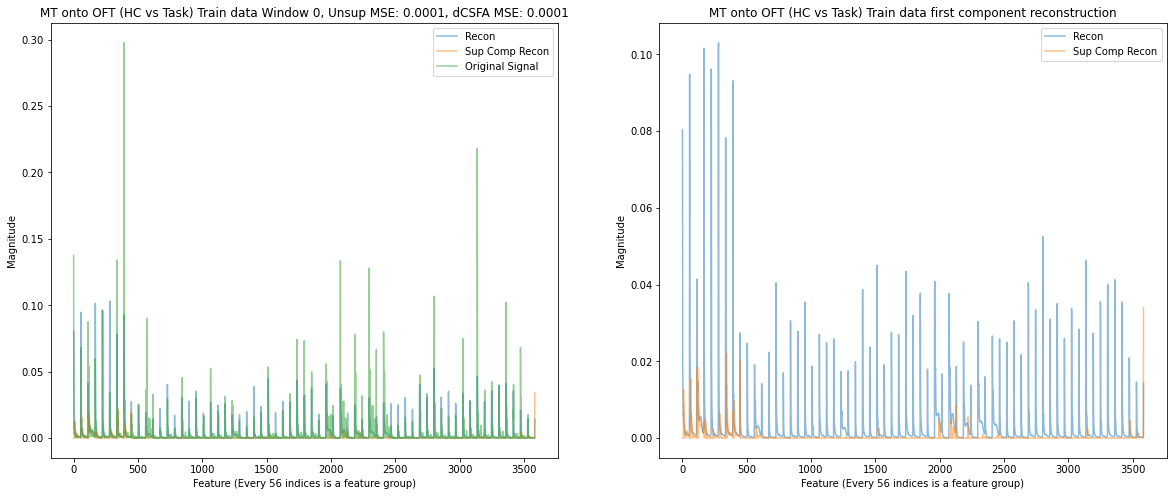

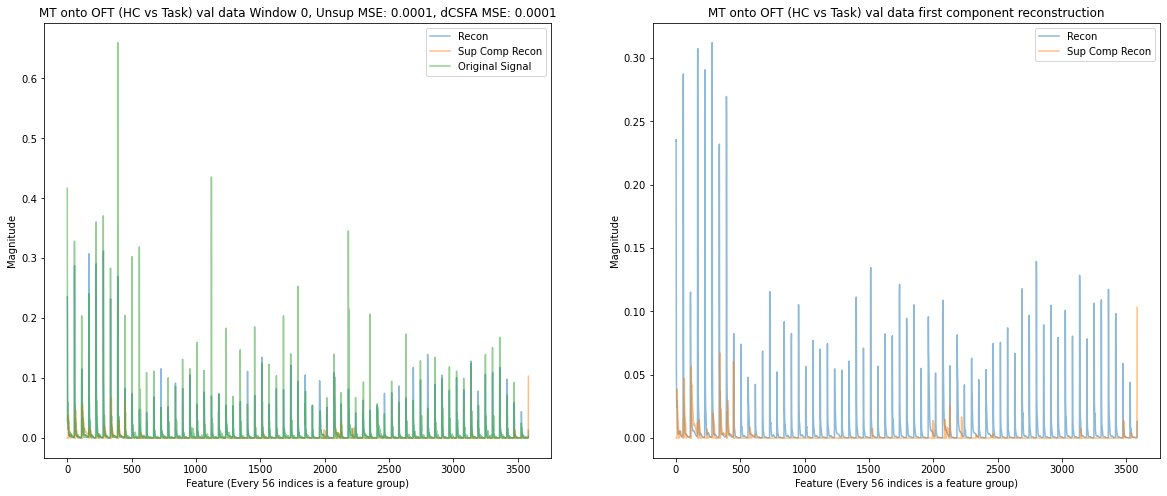

In [42]:


umc_dt.make_recon_plots(model,oft_X_train,0,task="MT onto OFT (HC vs Task) Train",saveFile="ds_mt_onto_oft_train_recon.png")
umc_dt.make_recon_plots(model,oft_X_val,0,task="MT onto OFT (HC vs Task) val",saveFile="ds_mt_onto_oft_val_recon.png")
df = make_projection_csv(OFT_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = r".\\DS_MT_onto_OFT_HC_vs_Task_Train_Projection_2022_March_25.csv")

df = make_projection_csv(OFT_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = r".\\DS_MT_onto_OFT_HC_vs_Task_Val_Projection_2022_March_25.csv")

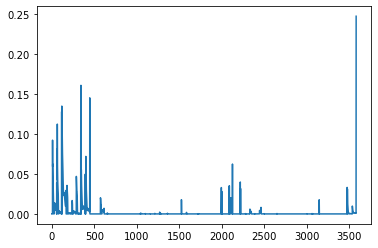

In [46]:
plt.plot(model.get_W_nmf().cpu().detach().numpy()[0,:])